

# **1. Libraries and Data Loading**


*   The necessary libraries are imported, and warnings are suppressed for cleaner output. The dataset is loaded into a DataFrame.


In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from google.colab import drive
drive.mount('/content/drive')

# Ignore warnings for cleaner output
warnings.filterwarnings("ignore")

# Load the data
file_path = '/content/drive/MyDrive/creditcard.csv'
data = pd.read_csv(file_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **2. Data Preprocessing**



*   Duplicates are removed from the dataset. The 'Amount' feature is normalized using StandardScaler, and the 'Time' feature is dropped. Only valid class labels (0 and 1) are retained, and the class labels are converted to integers.



In [ ]:
# Remove duplicates
print("Initial shape:", data.shape)
data.drop_duplicates(inplace=True)
print("Shape after removing duplicates:", data.shape)

# Normalize 'Amount' and drop 'Time'
data['NormalizedAmount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))
data.drop(['Time', 'Amount'], axis=1, inplace=True)

# Ensure class labels are integers
data = data[data['Class'].isin([0, 1])]
data['Class'] = data['Class'].astype(int)


Initial shape: (284807, 31)
Shape after removing duplicates: (283726, 31)


# **3. Class Distribution**



*  The distribution of classes before resampling is displayed to understand the class imbalance in the dataset.



In [ ]:
# Display class distribution
print("Class distribution before resampling:\n", data['Class'].value_counts())


Class distribution before resampling:
 Class
0    283253
1       473
Name: count, dtype: int64


# **4. Feature and Target Separation**



*  The dataset is split into features (X) and the target (y).



In [ ]:
# Splitting data into features and target
X = data.drop('Class', axis=1)
y = data['Class']


# **5. Handling Class Imbalance**



*  SMOTE (Synthetic Minority Over-sampling Technique) and RandomUnderSampler are used to create balanced datasets by oversampling the minority class and undersampling the majority class, respectively.


In [ ]:
# Handling class imbalance with SMOTE and RandomUnderSampler
smote = SMOTE(random_state=42, k_neighbors=5)
rus = RandomUnderSampler(random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)
X_rus, y_rus = rus.fit_resample(X, y)


# **6. Train-Test Split**



*   The datasets (original, SMOTE, undersampled) are split into training and testing sets for model training and evaluation.



In [ ]:
# Train-test split for original, SMOTE, and undersampled datasets
X_train_sm, X_test_sm, y_train_sm, y_test_sm = train_test_split(X_smote, y_smote, test_size=0.2, random_state=42)
X_train_rus, X_test_rus, y_train_rus, y_test_rus = train_test_split(X_rus, y_rus, test_size=0.2, random_state=42)
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X, y, test_size=0.2, random_state=42)


# **7. Model Training and Evaluation**



*   A function train_eval_model_cv is defined to train and evaluate models with cross-validation. This function fits the model, makes predictions, evaluates performance using classification reports and confusion matrices, and plots ROC curves. It also calculates cross-validation scores for ROC AUC.


In [ ]:
# Function to train and evaluate models with cross-validation
def train_eval_model_cv(X_train, y_train, X_test, y_test, model_cls, model_name="Model"):
    model = model_cls()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_probs = model.predict_proba(X_test)[:, 1]  # Probability estimates for the positive class

    # Evaluating the model
    print(f"{model_name} Classification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f"{model_name} Confusion Matrix")
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

    print(f"{model_name} ROC AUC Score: {roc_auc:.2f}")

    # Cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
    print(f"{model_name} Cross-Validation ROC AUC Scores: {cv_scores}")
    print(f"{model_name} Mean CV ROC AUC Score: {cv_scores.mean():.2f}")


# **8. Model Evaluation**



*   The function is called for Logistic Regression and Random Forest models on the original, SMOTE, and undersampled datasets to evaluate their performance.



Logistic Regression (Original) Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56656
           1       0.89      0.54      0.68        90

    accuracy                           1.00     56746
   macro avg       0.95      0.77      0.84     56746
weighted avg       1.00      1.00      1.00     56746



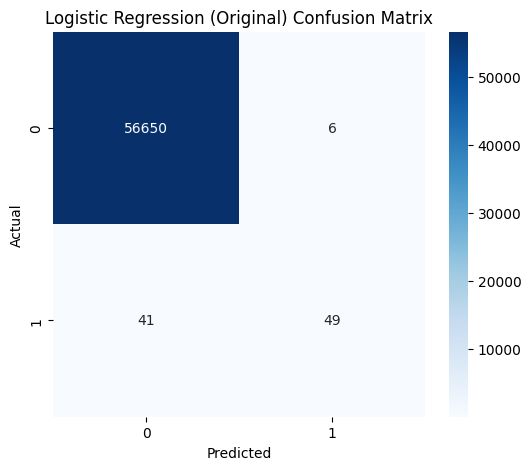

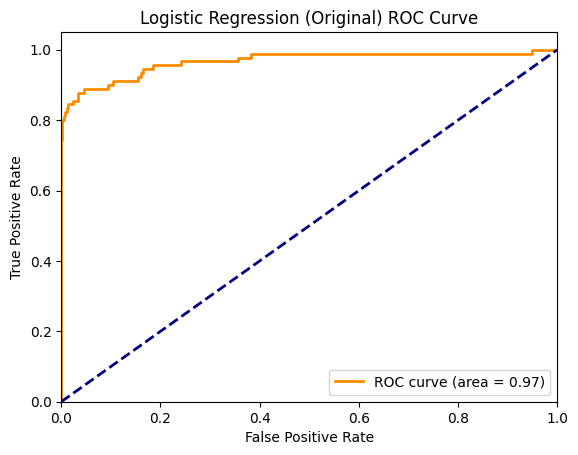

Logistic Regression (Original) ROC AUC Score: 0.97
Logistic Regression (Original) Cross-Validation ROC AUC Scores: [0.98359879 0.95969625 0.98011413 0.96106017 0.97472492]
Logistic Regression (Original) Mean CV ROC AUC Score: 0.97


In [ ]:
# Evaluate on original distribution for comparison
train_eval_model_cv(X_train_orig, y_train_orig, X_test_orig, y_test_orig, LogisticRegression, "Logistic Regression (Original)")


Random Forest (Original) Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56656
           1       0.97      0.72      0.83        90

    accuracy                           1.00     56746
   macro avg       0.98      0.86      0.91     56746
weighted avg       1.00      1.00      1.00     56746



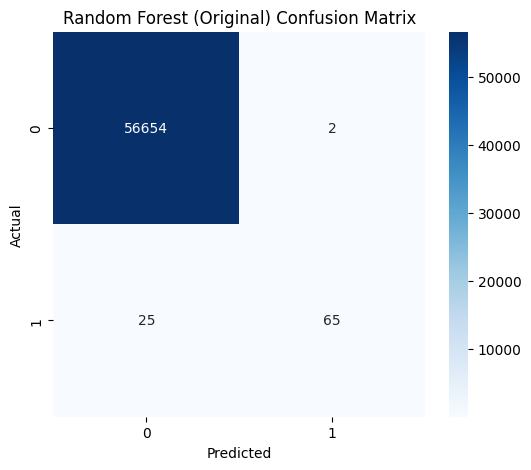

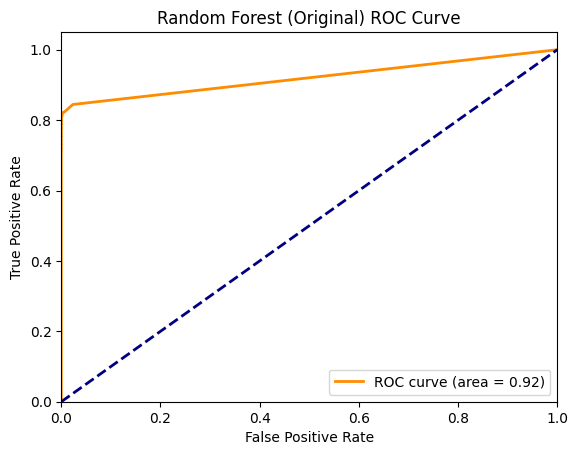

Random Forest (Original) ROC AUC Score: 0.92
Random Forest (Original) Cross-Validation ROC AUC Scores: [0.95246841 0.90538118 0.9728913  0.95341322 0.95327997]
Random Forest (Original) Mean CV ROC AUC Score: 0.95


In [ ]:
# Evaluate on original distribution for comparison
train_eval_model_cv(X_train_orig, y_train_orig, X_test_orig, y_test_orig, RandomForestClassifier, "Random Forest (Original)")

Logistic Regression (SMOTE) Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.97      0.95     56463
           1       0.97      0.91      0.94     56839

    accuracy                           0.94    113302
   macro avg       0.95      0.94      0.94    113302
weighted avg       0.95      0.94      0.94    113302



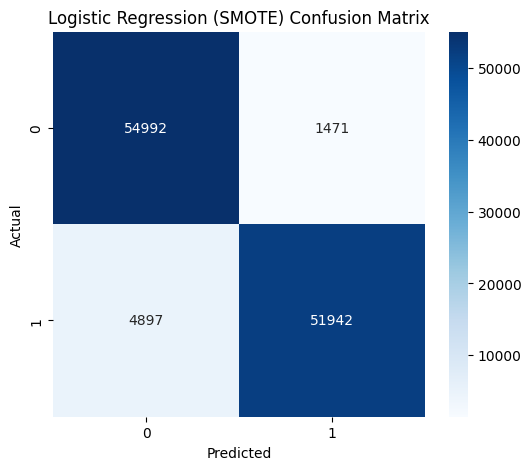

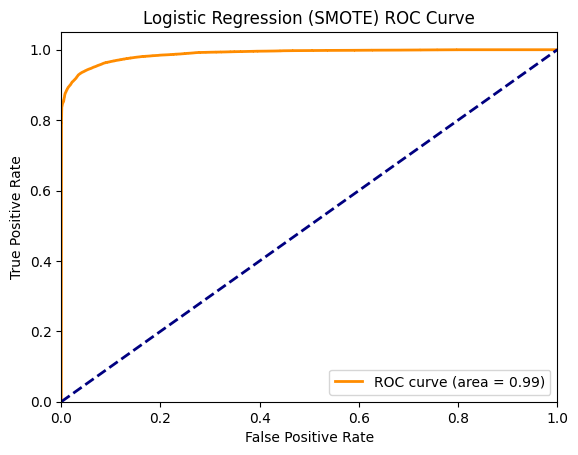

Logistic Regression (SMOTE) ROC AUC Score: 0.99
Logistic Regression (SMOTE) Cross-Validation ROC AUC Scores: [0.98873744 0.9885226  0.98858571 0.98824711 0.98851952]
Logistic Regression (SMOTE) Mean CV ROC AUC Score: 0.99


In [ ]:
# Re-evaluating previous models for comparison
train_eval_model_cv(X_train_sm, y_train_sm, X_test_sm, y_test_sm, LogisticRegression, "Logistic Regression (SMOTE)")


Random Forest (SMOTE) Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56463
           1       1.00      1.00      1.00     56839

    accuracy                           1.00    113302
   macro avg       1.00      1.00      1.00    113302
weighted avg       1.00      1.00      1.00    113302



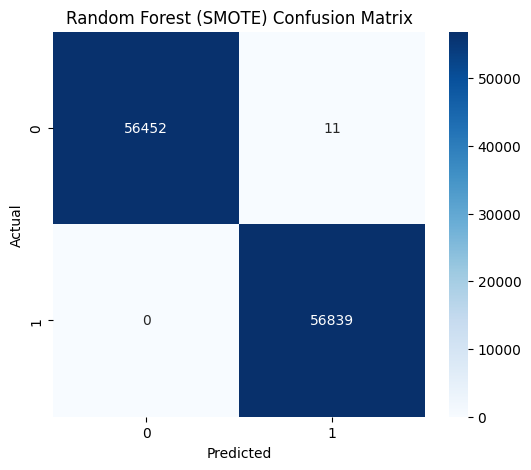

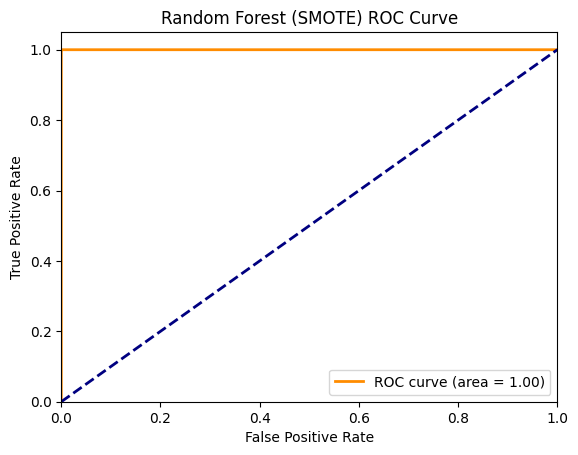

Random Forest (SMOTE) ROC AUC Score: 1.00
Random Forest (SMOTE) Cross-Validation ROC AUC Scores: [0.99999884 0.99999964 0.99999984 0.99998734 0.99998783]
Random Forest (SMOTE) Mean CV ROC AUC Score: 1.00


In [ ]:
train_eval_model_cv(X_train_sm, y_train_sm, X_test_sm, y_test_sm, RandomForestClassifier, "Random Forest (SMOTE)")

Logistic Regression (Undersampled) Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.95      0.93        88
           1       0.96      0.91      0.93       102

    accuracy                           0.93       190
   macro avg       0.93      0.93      0.93       190
weighted avg       0.93      0.93      0.93       190



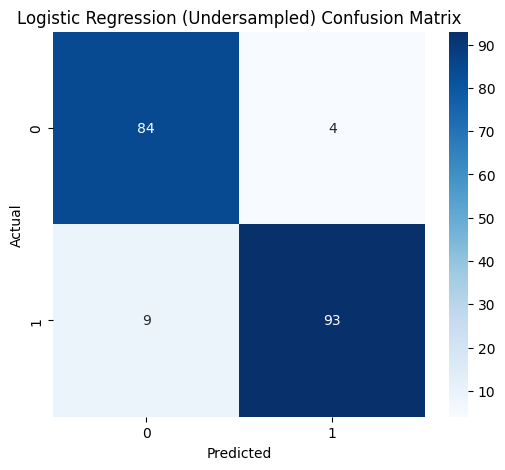

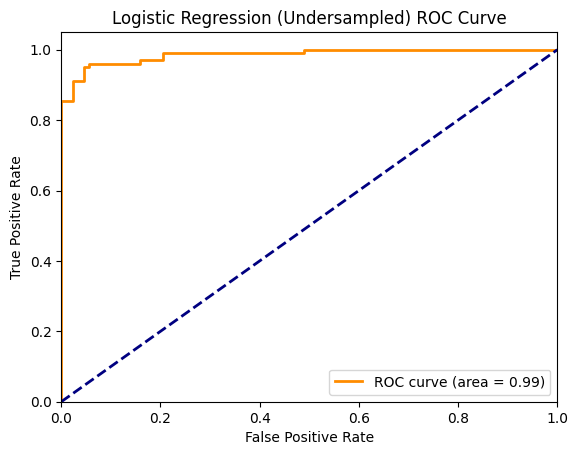

Logistic Regression (Undersampled) ROC AUC Score: 0.99
Logistic Regression (Undersampled) Cross-Validation ROC AUC Scores: [0.98354978 0.97876448 0.96560197 0.97314847 0.98104598]
Logistic Regression (Undersampled) Mean CV ROC AUC Score: 0.98


In [ ]:
train_eval_model_cv(X_train_rus, y_train_rus, X_test_rus, y_test_rus, LogisticRegression, "Logistic Regression (Undersampled)")

Random Forest (Undersampled) Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.98      0.93        88
           1       0.98      0.90      0.94       102

    accuracy                           0.94       190
   macro avg       0.94      0.94      0.94       190
weighted avg       0.94      0.94      0.94       190



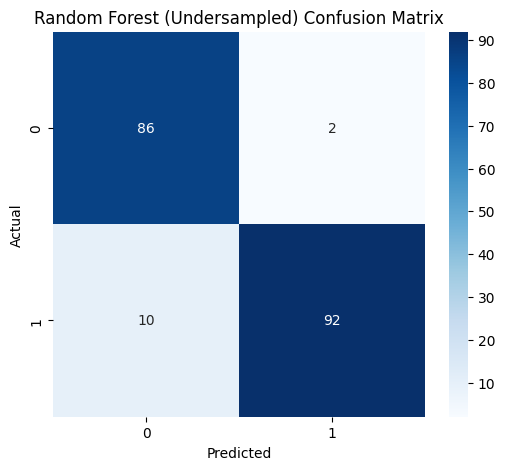

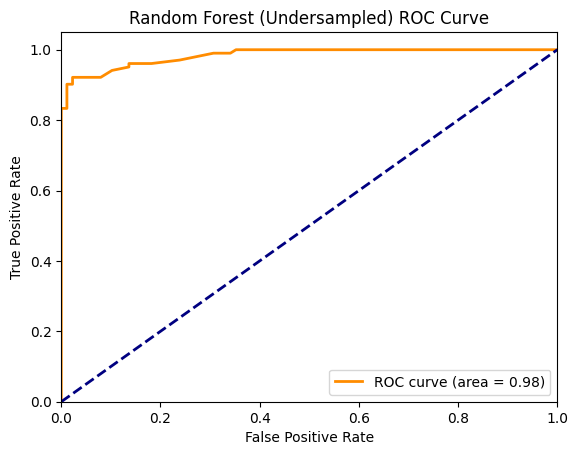

Random Forest (Undersampled) ROC AUC Score: 0.98
Random Forest (Undersampled) Cross-Validation ROC AUC Scores: [0.96069264 0.97902773 0.96823447 0.97095472 0.97920323]
Random Forest (Undersampled) Mean CV ROC AUC Score: 0.97


In [ ]:
train_eval_model_cv(X_train_rus, y_train_rus, X_test_rus, y_test_rus, RandomForestClassifier, "Random Forest (Undersampled)")

# **9. Result**

## Original Dataset


1.   Logistic Regression

 * Classification Report:
      *   Precision (Class 1): 0.89
      *   Recall (Class 1): 0.54
      * F1-Score (Class 1): 0.68
 * ROC AUC Score: 0.97
 * Mean CV ROC AUC Score: 0.97




2.   Random Forest

 * Classification Report:
      *   Precision (Class 1): 0.97
      *   Recall (Class 1): 0.72
      * F1-Score (Class 1): 0.83
 * ROC AUC Score: 0.92
 * Mean CV ROC AUC Score: 0.95











## SMOTE (Synthetic Minority Over-sampling Technique) Dataset

1.   Logistic Regression

 * Classification Report:
      *   Precision (Class 1): 0.97
      *   Recall (Class 1): 0.91
      * F1-Score (Class 1): 0.94
 * ROC AUC Score: 0.99
 * Mean CV ROC AUC Score: 0.99




2.   Random Forest

 * Classification Report:
      *   Precision (Class 1): 1.00
      *   Recall (Class 1): 1.00
      * F1-Score (Class 1): 1.00
 * ROC AUC Score: 1.00
 * Mean CV ROC AUC Score: 1.00


## Undersampled Dataset


1.   Logistic Regression

 * Classification Report:
      *   Precision (Class 1): 0.96
      *   Recall (Class 1): 0.91
      * F1-Score (Class 1): 0.93
 * ROC AUC Score: 0.99
 * Mean CV ROC AUC Score: 0.98




2.   Random Forest

 * Classification Report:
      *   Precision (Class 1): 0.98
      *   Recall (Class 1): 0.90
      * F1-Score (Class 1): 0.94
 * ROC AUC Score: 0.98
 * Mean CV ROC AUC Score: 0.97


# **10. Analysis**



*   Original Dataset

  * Logistic Regression shows high accuracy and ROC AUC scores but suffers from low recall for the minority class (Class 1), indicating many false negatives.
  * Random Forest improves recall for Class 1 but does not match the ROC AUC score of Logistic Regression.




* SMOTE Dataset:
 *  Both Logistic Regression and Random Forest significantly improve recall and overall performance, with Random Forest achieving perfect scores. This suggests that SMOTE effectively balances the dataset and enhances model performance on the minority class.


*  Undersampled Dataset:
  *   Both models achieve a balanced performance with similar precision, recall, and f1-scores. The ROC AUC scores are also high, demonstrating the effectiveness of undersampling for handling class imbalance.






# **11. Conclusion**


* SMOTE provides the best performance for both models, especially for Random Forest, which achieves perfect scores.
* Logistic Regression and Random Forest both benefit from SMOTE and undersampling, but Random Forest generally performs better, particularly with SMOTE.
* Choosing SMOTE with Random Forest would be the optimal strategy for handling the class imbalance in this dataset, ensuring high recall, precision, and overall predictive performance.


